<a href="https://colab.research.google.com/github/samuel-haddad/MBAUSP/blob/main/gpboost_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Multinível**

#### MBA Data Science & Analytics - USP & ESALQ
Trabalho de Conclusão de Curso - 02/2022 <br>
**Título:** Um estudo comparativo entre modelos Multinível, Logístico e XGBoost na detecção de fraudes ideológicas no setor financeiro. <br>
**Autor:** Samuel Haddad Simões Machado
<br>

## Bibliotecas

In [1]:
%%capture
# install libs
!pip install gpboost

In [2]:
# pacotes básicos
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# modelagem
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import precision_recall_curve
import gpboost as gpb
from gpboost import GPBoostClassifier

# google libs & auth
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

## Dataset

In [3]:
# importar o dataset
sht1 = gc.open_by_key('14di6Prcuk4vAGsd43r60cnKcZh_M6ziQV8Ht7xcJ0b4')
df_sheet = sht1.get_worksheet(0)
df_data = df_sheet.get_all_records()

# criar o dataframe
df = pd.DataFrame(df_data)

# visualizar os dados
df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var283,var284,var285,var286,var287,var288,var289,target,group,id
0,0.422658,0.030134,0.502699,-0.150856,-1.408410,0.008990,1,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,20,26
1,0.422658,0.662074,0.378098,-0.352544,-2.600380,0.549807,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,20,54
2,-0.277668,-0.024085,0.414200,0.068187,0.975530,0.549807,0,0,1,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,18,105
3,-0.243825,0.662074,-1.792512,1.268581,1.174192,-1.072644,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,18,154
4,0.086277,0.662074,0.608747,-0.352544,-0.613763,0.549807,0,1,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,27,182


## Treino, teste e validação

In [4]:
# remover a coluna de id
df_silver = df.drop(['id'], axis=1)

# extrair as variáveis explicativas e resposta
X, y, group = df_silver.drop(['group', 'target'], axis=1), df_silver['target'], df_silver['group']

# separar a base de treino
X_train, X_rem, y_train, y_rem, group_train, group_rem = train_test_split(X, y, group, train_size=0.6, random_state=42)
 
# separar as bases de teste e validação
X_val, X_test, y_val, y_test, group_val, group_test = train_test_split(X_rem, y_rem, group_rem, test_size=0.5, random_state=42)

# distribuição da variável resposta nas bases
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)

# countagem dos grupos
m_train = len(np.unique(group_train))
m_val = len(np.unique(group_val))
m_test = len(np.unique(group_test))


# exibir a volumetria das bases
print('+', 25*'-','RESUMO', 25*'-','+')
print(f'X_test: {X_test.shape} | y_test: {len(y_val)} | y_val: {len(y_val)}')
print(f'm_train: {m_train} | m_test: {m_test} | m_val: {m_val}')
print(f'Train dist: {round(y_train_dist*100, 2)}% | Test dist: {round(y_test_dist*100, 2)}%')
print('+', 58*'-', '+')

+ ------------------------- RESUMO ------------------------- +
X_test: (2968, 289) | y_test: 2968 | y_val: 2968
m_train: 36 | m_test: 32 | m_val: 33
Train dist: 38.23% | Test dist: 38.71%
+ ---------------------------------------------------------- +


## Modelagem

In [ ]:
# parâmetros iniciais 
likelihood = "bernoulli_probit"
num_boost_round = 500

#---------- Treinamento  ----------#

# Criação do modelo multinível
gp_model = gpb.GPModel(group_data=group_train, likelihood=likelihood)

# Detalhamento das etapas para monitoramento da convergência do modelo passo a passo
gp_model.set_optim_params(params={"trace": False})

# Criar o dataset de treinamento
data_train = gpb.Dataset(X_train, y_train)

# Especificar o parâmetroa iniciais de boosting
params = {'learning_rate': 0.1
          ,'min_data_in_leaf': 1
          ,'objective': 'binary'
          }

# treinando o modelo com os parâmtros de boosting
bst = gpb.train(params=params
                ,train_set=data_train
                ,gp_model=gp_model
                ,num_boost_round=num_boost_round
                )

# gpb Classifier
model = gpb.GPBoostClassifier(objective='binary')

# init_model=bst
model.fit(X=X_train, y=y_train, gp_model=gp_model, init_model=bst)

# previsão - teste
y_pred_test = model.predict(X_test,  group_data_pred=group_test)

# extrair as probabilidades
yhat = model.predict_proba(X_test, group_data_pred=group_test)['response_mean']

# extrair as métricas - test
acuracy_test = (metrics.accuracy_score(y_test, y_pred_test)*100).round(2)
precision_test = (metrics.precision_score(y_test, y_pred_test)*100).round(2)
recall_test = (metrics.recall_score(y_test, y_pred_test)*100).round(2)
aucroc_test = (roc_auc_score(y_test, yhat)*100).round(2)
f1_score_test = (f1_score(y_test, y_pred_test)*100).round(2)
logloss_test = (metrics.log_loss(y_test, yhat, normalize=True))

#---------- TUNNING ----------#

# Choosing tuning parameters
param_grid = {'learning_rate': [1,0.1,0.01]
              ,'min_data_in_leaf': [1,10,100]
              ,'max_depth': [1,3,5,10,-1]
              }

opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid
                                             ,params=params
                                             ,num_try_random=None
                                             ,nfold=4
                                             ,gp_model=gp_model
                                             ,use_gp_model_for_validation=True
                                             ,train_set=data_train
                                             ,verbose_eval=0
                                             ,num_boost_round=1000
                                             ,early_stopping_rounds=10
                                             ,seed=1000
                                             ,metrics='auc'
                                             )


params = {**opt_params['best_params'], 'objective': 'binary'}

# Cross-validation para determinar o número de iterações
cvbst = gpb.cv(params=params
               ,train_set=data_train
               ,gp_model=gp_model
               ,use_gp_model_for_validation=True
               ,num_boost_round=1000
               ,nfold=4
               ,verbose_eval=False
               ,show_stdv=False
               ,seed=1
               )
metric_name = list(cvbst.keys())[0]
num_iteration = np.argmin(cvbst[metric_name])

[GPBoost] [Info] Total Bins 1814
[GPBoost] [Info] Number of data points in the train set: 8903, number of used features: 289
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=-0.412645
[GPBoost] [Info] Start training from score -0.412645
[GPBoost] [Info] Total Bins 1701
[GPBoost] [Info] Number of data points in the train set: 6675, number of used features: 289
[GPBoost] [Info] Total Bins 1697
[GPBoost] [Info] Number of data points in the train set: 6675, number of used features: 289
[GPBoost] [Info] Total Bins 1714
[GPBoost] [Info] Number of data points in the train set: 6675, number of used features: 289
[GPBoost] [Info] Total Bins 1699
[GPBoost] [Info] Number of data points in the train set: 6675, number of used features: 289
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=-0.394915
[GPBoost] [Info] Start training from score -0.394915
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=-0.442389
[GPBoost] [Info] Start tra

In [ ]:
print("Best parameters: " + str(opt_params['best_params']))
print("Best number of iterations(grid search): " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best number of iterations (cv): " + str(np.argmin(cvbst[metric_name])))


Best parameters: {'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 3}
Best number of iterations(grid search): 168
Best score: 0.7825639838409554
Best number of iterations (cv): 198


In [ ]:
#---------- VALIDAÇÃO ----------#

# construir o modelo com parâmetros otimizados

# gpb Classifier
model = gpb.GPBoostClassifier(**opt_params['best_params'], objective='binary')

# init_model=bst
model.fit(X=X_train, y=y_train, gp_model=gp_model, init_model=bst)

# previsão - validação
y_pred = model.predict(X_val, num_iteration=num_iteration, group_data_pred=group_val)

# extrair as probabilidades
yhat = model.predict_proba(X_val, num_iteration=num_iteration, group_data_pred=group_val)['response_mean']

# extrair as métricas - validação
acuracy_val = (metrics.accuracy_score(y_val, y_pred)*100).round(2)
precision_val = (metrics.precision_score(y_val, y_pred)*100).round(2)
recall_val = (metrics.recall_score(y_val, y_pred)*100).round(2)
aucroc_val = (roc_auc_score(y_val, yhat)*100).round(2)
f1_score_val = (f1_score(y_val, y_pred)*100).round(2)
logloss_val = (metrics.log_loss(y_val, yhat, normalize=True))

# criar o dataframe comparativo
columns= ['amostra', 'acuracia', 'precisao', 'recall', 'auc_roc', 'f1_score', 'logloss(normalizada)']
data = [('teste', acuracy_test, precision_test, recall_test, aucroc_test, f1_score_test, logloss_test)
        ,('validacao', acuracy_val, precision_val, recall_val, aucroc_val, f1_score_val, logloss_val)
        ]
df_metrics = pd.DataFrame(data=data, columns=columns)

# parâmetro aleatório (covariância)
print(gp_model.summary()) 

# visualizar resultados do grid search
print('+', 18*'-','RESULTADO GRID SEARCH', 18*'-','+')
print('Parâmetros: \n', model.get_params())
print("Melhor número de iterações (cv): " + str(np.argmin(cvbst[metric_name])))
print('+', 59*'-', '+')

# visualizar tabela comparativa
df_metrics

[GPBoost] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
Covariance parameters (random effects):
       Param.
group  0.0617
+ ------------------ RESULTADO GRID SEARCH ------------------ +
Parâmetros: 
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'min_data_in_leaf': 1}
Melhor número de iterações (cv): 198
+ ----------------------------------------------------------- +


,amostra,acuracia,precisao,recall,auc_roc,f1_score,logloss(normalizada)
0,teste,74.46,70.13,59.27,79.06,64.25,0.549547
1,validacao,75.10,70.64,59.61,80.35,64.66,0.520409


## Gráficos

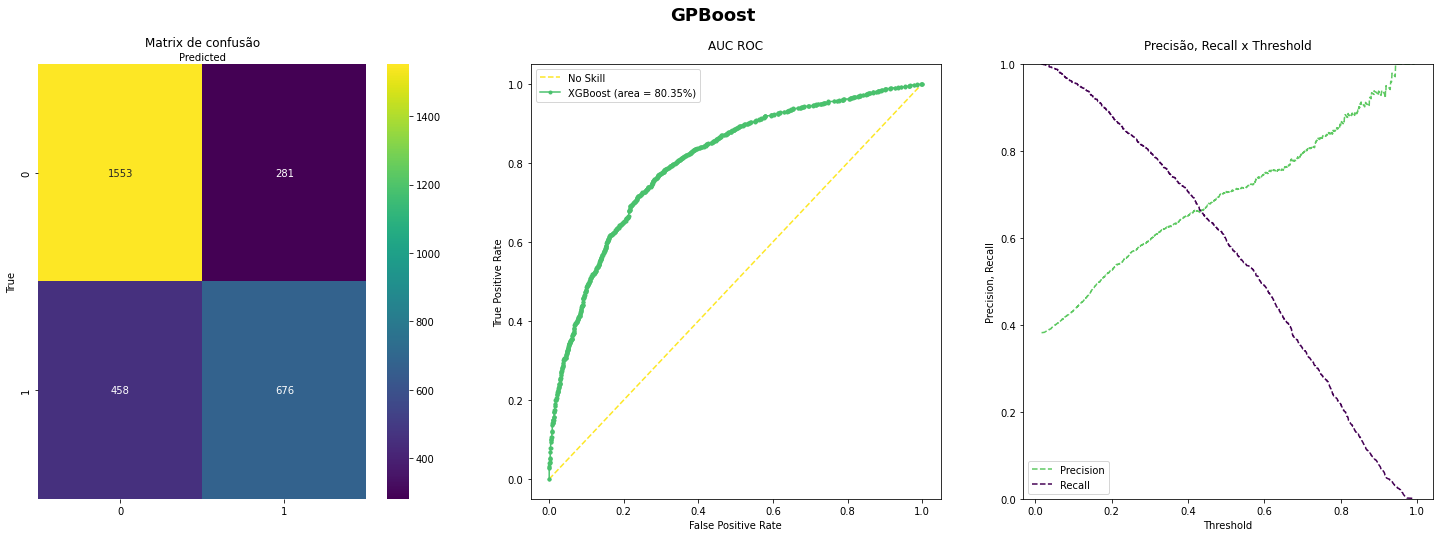

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), gridspec_kw=({'hspace':0.5}))
fig.suptitle('GPBoost', fontsize=18, weight='semibold', y=0.98)
pad = 15

#---------- matriz de confusão ----------#
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 1)

labels = [0, 1]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# criar o heatmap
ax = sns.heatmap(data=pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
ax.xaxis.set_label_position("top")
ax.set_title('Matrix de confusão')
plt.ylabel('True')
plt.xlabel('Predicted');

#---------- auc roc ----------#
fpr, tpr, thresholds = roc_curve(y_val, yhat)

# plot da curva roc
plt.subplot(1, 3, 2)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='XGBoost (area = {}%)'.format(aucroc_val))

# axis labels
plt.title('AUC ROC', pad=pad)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

#---------- precisão, recall x threshold ----------#
precision, recall, thresholds = precision_recall_curve(y_val, yhat) 

plt.subplot(1, 3, 3)
plt.title('Precisão, Recall x Threshold', fontsize=12, pad=pad)
plt.plot(thresholds, precision[: -1], "b--", label="Precision", color='#5ec962')
plt.plot(thresholds, recall[: -1], "r--", label="Recall", color='#440154')
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);